In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
import time

In [2]:
'''
Load in dataframe:
'''

fnameBG = './files/BG_NEW_1d.h5'
df_BG_particles = pd.read_hdf(fnameBG, 'Particles')

fname = './files/Xe2nu_NEW_1d_brem.h5'
df_particles = pd.read_hdf(fname, 'Particles')

In [3]:
'''
Make fiducial and S2 cuts for all data:
'''

df_BG_particles = df_BG_particles[(df_BG_particles['nS2'] == 1)&(df_BG_particles['reco_z_min'] > 20)&(df_BG_particles['reco_z_max'] < 510)&(df_BG_particles['reco_r_max'] < 178)]

df_particles = df_particles[(df_particles['nS2'] == 1)&(df_particles['reco_z_min'] > 20)&(df_particles['reco_z_max'] < 510)&(df_particles['reco_r_max'] < 178)]

In [4]:
'''
Make remaining analysis cuts here:
'''

df_BG_particles_selection = df_BG_particles[(df_BG_particles['reco_numb_of_tracks'] == 1)&(df_BG_particles['reco_ovlp_blob_energy'] == 0.0)
                                      &(df_BG_particles['reco_eblob2']*1000 > 355.55*(1-np.exp(-0.00133*df_BG_particles['reco_energy']*1000)))]

df_particles_selection = df_particles[(df_particles['reco_numb_of_tracks'] == 1)&(df_particles['reco_ovlp_blob_energy'] == 0.0)
                                      &(df_particles['reco_eblob2']*1000 > 355.55*(1-np.exp(-0.00133*df_particles['reco_energy']*1000)))]

### eplot
<br>
The following cell is a function called "eplot" and is used to plot the reconstructed energy whether it be selected or not selected with whatever set of weights necessary. To use it you must define whether you want to plot the selected reconstructed energy or total reconstructed energy in the reco_energy spot, and then input the weight vector to pair with it, then the sample size variable used, and finally a string that names the physics variable being studied.

In [5]:
def eplot(reco_energy, weight, sample_size, name):
    
    fig, ax = plt.subplots(nrows=2, figsize=(10,10), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

    ebins = np.linspace(1,2.3,100)
    bin_centers = (ebins[1:] + ebins[:-1])/2
    energy_counts,_ = np.histogram(reco_energy, bins=ebins)

    #Creating matrices for the total and average histogram counts
    energy_counts_reweight_all = np.zeros((sample_size,len(energy_counts)))
    energy_counts_reweight = np.zeros(len(energy_counts))

    #For loop that stores the histogram values for the counts into the previously created matrices
    for i in range(0,sample_size):
        energy_counts_reweight_hist,_ = np.histogram(reco_energy, bins=ebins, weights=weight[i])
        energy_counts_reweight_all[i] = energy_counts_reweight_hist

    #Calcluates the average of all the values and stores that into the energy_counts_reweight matrix
    energy_counts_reweight = energy_counts_reweight_all.mean(0)
    #Calculates the standard deviation of the calculated values and the sqrt of the counts for the total error
    yerr_tot = energy_counts_reweight_all.std(0) + np.sqrt(energy_counts_reweight)

    # Reweighted Counts
#     ax[0].errorbar(bin_centers, energy_counts_reweight, yerr=yerr_tot, fmt='o', label='Reweighted\n reconstructed\n background tracks\n w/ systematic uncertainty');
    #Original counts - Not Reweighted
    ax[0].errorbar(bin_centers, energy_counts, yerr=yerr_tot, fmt='.', label='Reconstructed\n background tracks\n w/ systematic uncertainty');

    ax[1].plot(bin_centers, energy_counts_reweight_all.std(0)/energy_counts_reweight, label='Systematic')
    ax[1].plot(bin_centers, np.sqrt(energy_counts_reweight_all.mean(0))/energy_counts_reweight_all.mean(0), label='Statistical')

    ax[1].set_xlabel('Total reconstructed event energy [MeV]', fontsize=16)
    ax[0].set_ylabel('Events', fontsize=16)
    ax[1].set_ylabel('Fractional \nUncertainty', fontsize = 16)
    ax[0].tick_params(which='major', axis='both', labelsize=16)
    ax[0].set_title('Effect of ' + name +'\n', fontweight = 'bold', fontsize = 25)

    ax[0].legend(loc='upper right', fontsize=16)
    ax[1].legend(loc='upper left', fontsize=16)

    return (energy_counts_reweight_all.std(0)/energy_counts_reweight).mean()

### Brem Weight Calculation
The following calculation uses two stages of for loops to randomly select variables that are used to perform the calculation with, this random sampling should eliminate the uncertainty/bias in the calculation as best as possible. 
<br>
<br>
The first loop selects a random systematic uncertainty for the weight calculation from a normal distribution situated around 0 with a width of 0.1, giving basically a random systematic uncertainty in the range of +/- 10%.
<br>
<br>
The first for loop also randomaly selects a width for which the energy bins can be sliced into several chunks of bins. This should eliminate any energy bias in the calculation. 
<br>
<br>
The second for loop calculates the weights of the events based on the radomly selected systematic uncertainty and runs through the loop however many times is necessary to calculate the weight of every bin using the slice width that was selected.
<br>
To calculate the weights, we take the ratio of Poisson's with the new rate to the old rate:
<br><br>
$w_k = \frac{f_1(k)}{f_0(k)} = e^{-(\lambda_1 - \lambda_0)}(\frac{\lambda_1}{\lambda_0})^k$.
<br><br>
where $\lambda_1 = \lambda_0(1 \pm Systematic Uncertainty)$ 
<br>
<br>
The first for loop for selecting the sample size can be run as many times as is necessary, however a sample size of around 2800 to 3000 is where the ending values tend to be very steady. 

In [6]:
sample_size = 3000

def brem_weight(particles):
    
    sample_size = 3000
    
    brem_weight = np.zeros((sample_size,len(particles['n_brems'])))

    #Begin for loop that calculates the weights for each randomly selected uncertainty from 1% - 10% and randomly selected bin width from .2 to 2
    for j in range(0,sample_size):
        syst_unc = np.random.normal(0, 0.1)
        eslice_width = np.random.uniform()*(2-.2)+.2
        ebins = np.arange(0, 4.0, eslice_width)
        ebins[-1] = 100
        for i in range(len(ebins)-1):
            eslice = (particles['reco_energy'] >= ebins[i])&(particles['reco_energy'] < ebins[i+1])
            rate0 = particles[eslice]['n_brems'].mean()
            rate1 = rate0*(1 + syst_unc)
            if rate0 != 0:
                particles.loc[eslice, 'weight'] = np.exp(-(rate1-rate0))*(rate1/rate0)**particles[eslice]['n_brems']
            if rate0 == 0:
                particles.loc[eslice, 'weight'] = 0**particles[eslice]['n_brems']
        #stores the weights for an uncertainty
        brem_weight[j] = particles['weight']
   
    return brem_weight

grouped_particles_selection = df_particles_selection.groupby('event').first()

t0 = time.clock()

weight_all_BG = brem_weight(df_BG_particles)
weight_all_selection_BG = brem_weight(df_BG_particles_selection)

weight_all = brem_weight(df_particles)
weight_all_selection = brem_weight(df_particles_selection)
weight_all_selection_g = brem_weight(grouped_particles_selection)

t1 = time.clock()-t0
print('Time Elapsed:', t1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] 

Time Elapsed: 3925.366101979


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Average Background Uncertainty:0.026679464093013007
Average Selected Background Uncertainty:0.026744139267279428
Average Uncertainty:0.02203934190183438
Average Selected Uncertainty:0.01791068441991967
Average Selected Grouped Uncertainty:0.017640055801771623


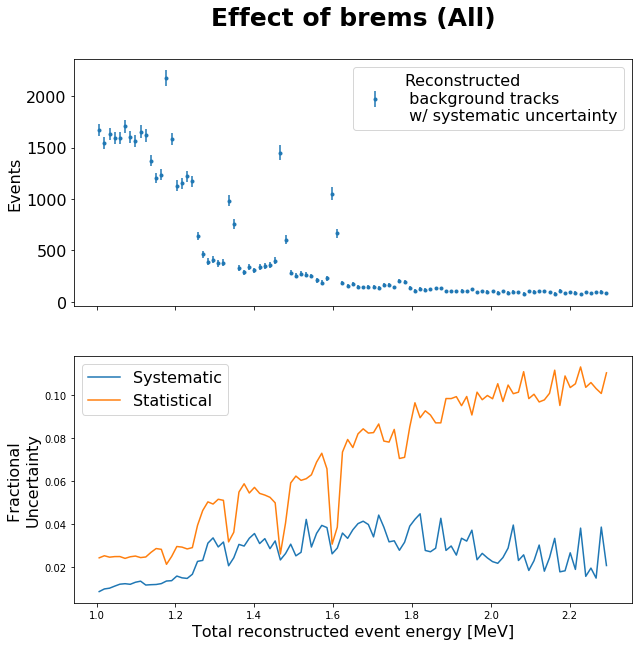

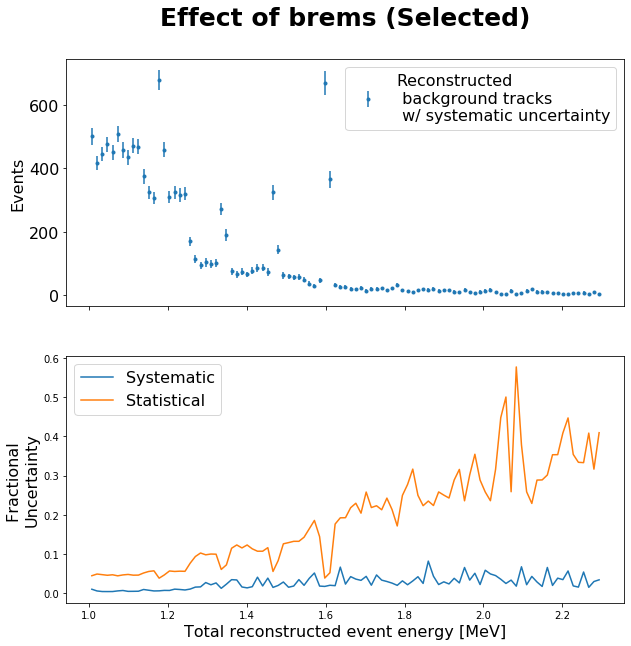

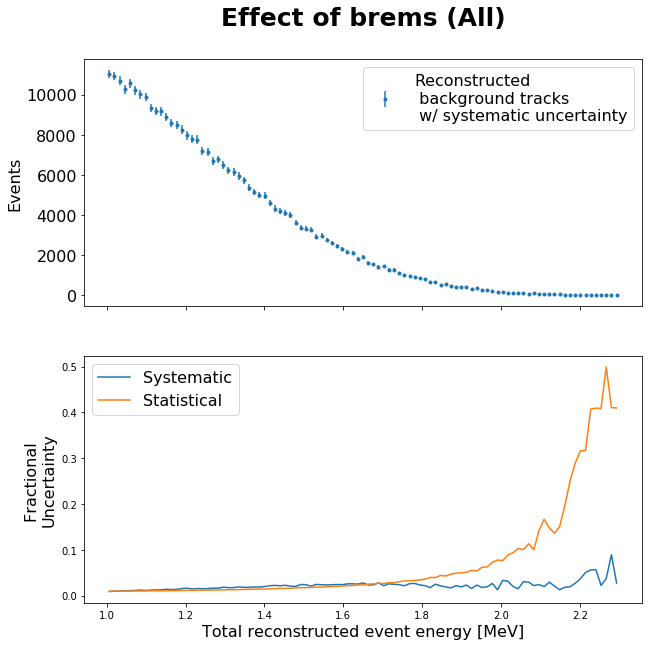

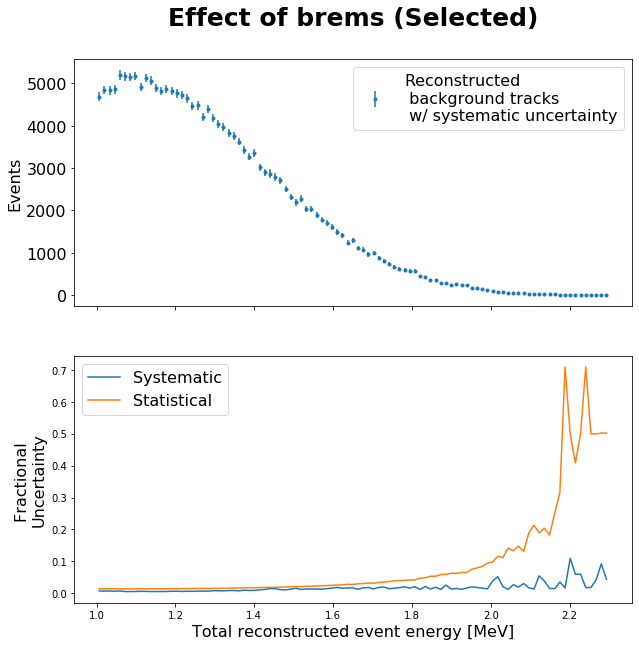

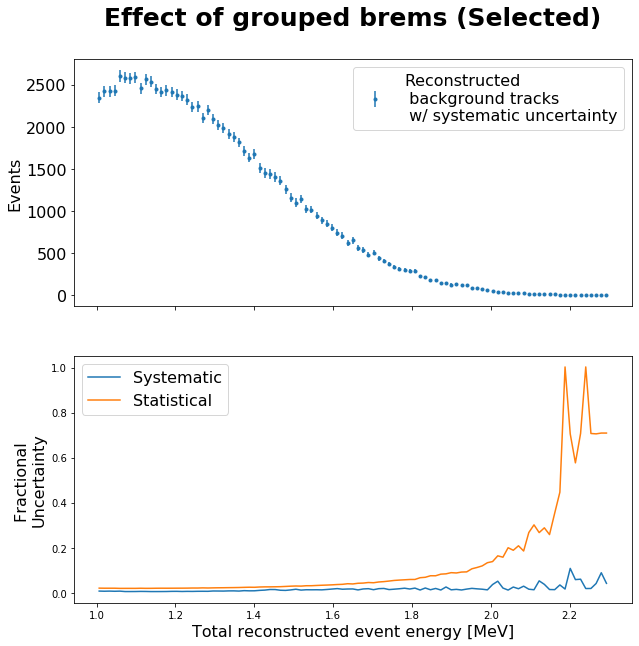

In [7]:
brem_weight_ave_BG = eplot(df_BG_particles['reco_energy'], weight_all_BG, sample_size, 'brems (All)')
brem_weight_ave_selected_BG = eplot(df_BG_particles_selection['reco_energy'], weight_all_selection_BG, sample_size, 'brems (Selected)')

brem_weight_ave = eplot(df_particles['reco_energy'], weight_all, sample_size, 'brems (All)')
brem_weight_ave_selected = eplot(df_particles_selection['reco_energy'], weight_all_selection, sample_size, 'brems (Selected)')
brem_weight_ave_selected_g = eplot(grouped_particles_selection['reco_energy'], weight_all_selection_g, sample_size, 'grouped brems (Selected)')

print('Average Background Uncertainty:' + str(brem_weight_ave_BG))
print('Average Selected Background Uncertainty:' + str(brem_weight_ave_selected_BG))

print('Average Uncertainty:' + str(brem_weight_ave))
print('Average Selected Uncertainty:' + str(brem_weight_ave_selected))
print('Average Selected Grouped Uncertainty:' + str(brem_weight_ave_selected_g))

## Mulitple Scattering Angle

### Multiple Coulomb Scattering Weight Calculation
<br>
The cell below calculates the weights by shifting the multiple scattering angle up or down by some fraction (syst_unc). The weight is calculated by removing that fraction of events:
<br><br>
$ 1.0*(1-sys\_unc)$
<br><br>
and adding it to the adjacent bin:
<br><br>
$\frac{mcs\_counts[i\pm1]}{mcs\_counts[i]}*sys\_unc$
<br><br>
If the sys_unc is positive the fraction of events are added to the [ i-1 ] bin and if the sys_unc is negative the fraction of events is added to the [ i+1 ] bin.
<br>
<br>
To calculate the weight due to the multiple scattering angle an overall uncertainty of 10% was used.

In [8]:
df_particles['mcs_min'] = df_particles.groupby('event')['mcs_angle'].transform('min')
df_particles['mcs_max'] = df_particles.groupby('event')['mcs_angle'].transform('max')
df_particles_selection['mcs_min'] = df_particles_selection.groupby('event')['mcs_angle'].transform('min')
df_particles_selection['mcs_max'] = df_particles_selection.groupby('event')['mcs_angle'].transform('max')

sample_size = 3000

def mcs_weight(particles, angle):
    
    sample_size = 3000
    
    weight_mcs = np.zeros((sample_size, len(particles[angle])))

    for j in range(0,sample_size):
        syst_unc = np.random.normal(0, 0.1)
        bin_width = np.random.uniform()*(1-.1)+.1

        mcsbins = np.arange(0, 3.15, bin_width)

        particles['weight_mcs'] = 1.

        mcs_counts,_ = np.histogram(particles[angle], bins=mcsbins)
        weight_vec = np.ones(len(mcsbins) - 1)

        for i in range(len(mcsbins) - 1):
            bin_slice = (particles[angle] >= mcsbins[i])&(particles[angle] < mcsbins[i+1])
            if syst_unc > 0 and i != 0:
                particles.loc[bin_slice, 'weight_mcs'] = (1-syst_unc) + mcs_counts[i-1]/mcs_counts[i]*syst_unc
                weight_vec[i] = (1-syst_unc) + mcs_counts[i-1]/mcs_counts[i]*syst_unc
            elif syst_unc <= 0 and i+1 != len(mcs_counts):
                particles.loc[bin_slice, 'weight_mcs'] = (1-syst_unc) + mcs_counts[i+1]/mcs_counts[i]*syst_unc
                weight_vec[i] = (1-syst_unc) + mcs_counts[i+1]/mcs_counts[i]*syst_unc

        weight_norm = len(particles)/particles['weight_mcs'].sum()

        particles['weight_mcs'] = particles['weight_mcs']*weight_norm

        weight_mcs[j] = particles['weight_mcs']
        
    return weight_mcs



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Average Background Uncertainty:0.01108009999265393
Average Selected Background Uncertainty:0.006687867046071734
Average Uncertainty:0.003453043694404341
Average Selected Uncertainty:0.004114319977632604


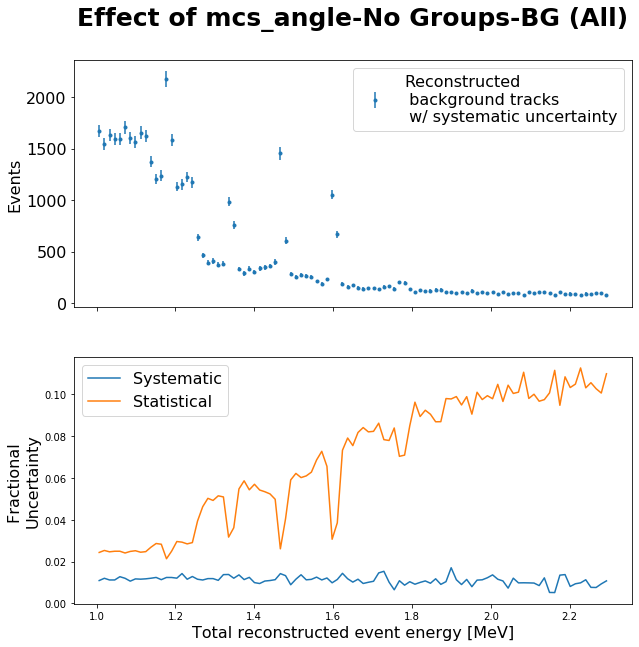

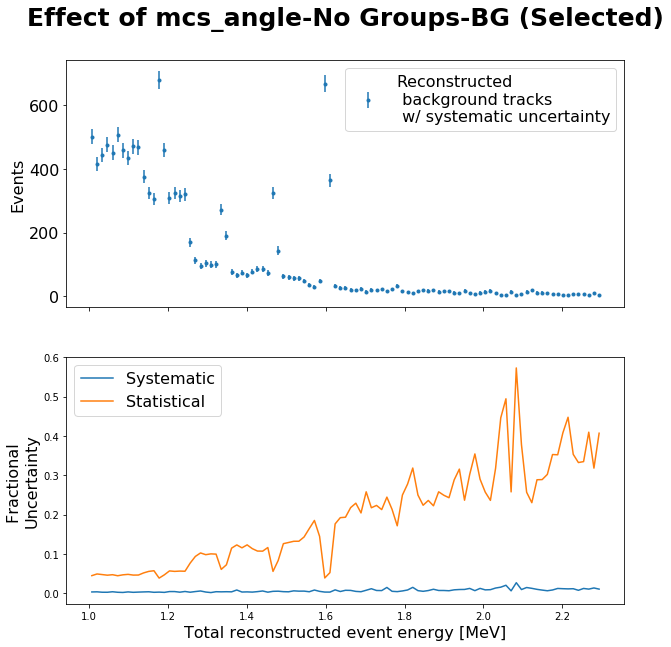

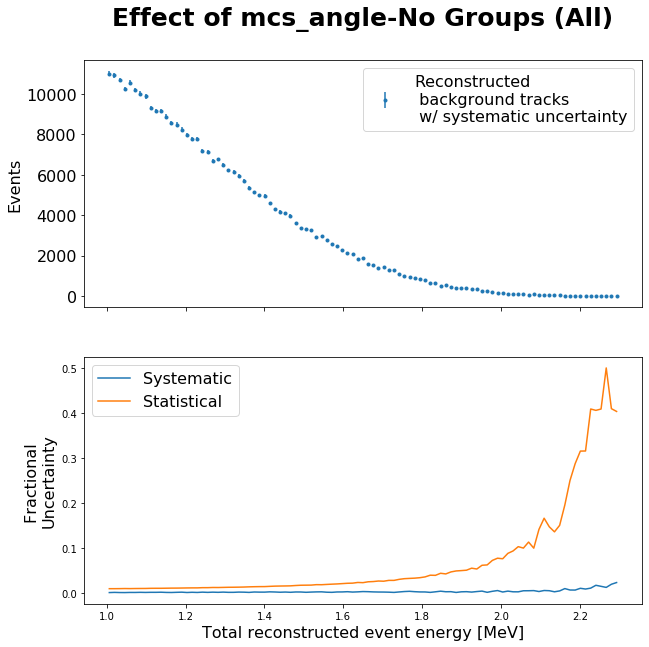

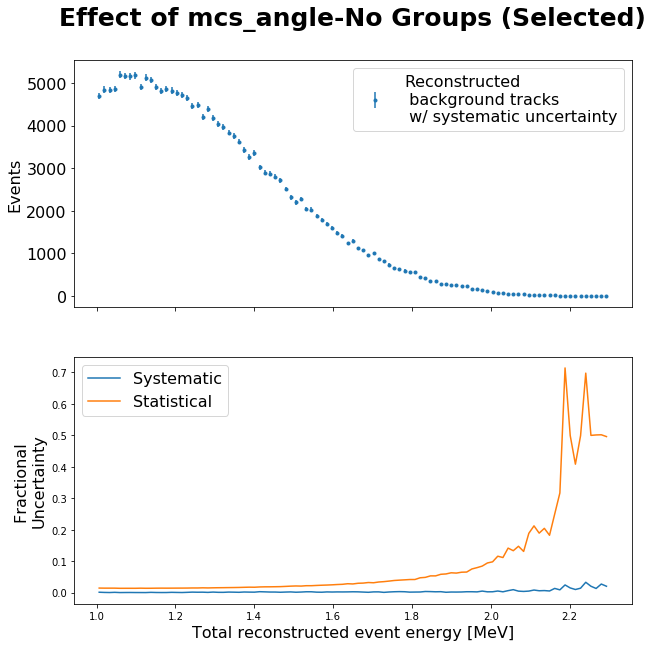

In [9]:
weight_mcs_all_BG = mcs_weight(df_BG_particles, 'mcs_angle')
weight_mcs_selection_BG = mcs_weight(df_BG_particles_selection, 'mcs_angle')
weight_mcs_all = mcs_weight(df_particles, 'mcs_angle')
weight_mcs_selection = mcs_weight(df_particles_selection, 'mcs_angle')

mcs_weight_ave_BG = eplot(df_BG_particles['reco_energy'], weight_mcs_all_BG, sample_size, 'mcs_angle-No Groups-BG (All)')
mcs_weight_ave_selected_BG = eplot(df_BG_particles_selection['reco_energy'], weight_mcs_selection_BG, sample_size, 'mcs_angle-No Groups-BG (Selected)')
mcs_weight_ave = eplot(df_particles['reco_energy'], weight_mcs_all, sample_size, 'mcs_angle-No Groups (All)')
mcs_weight_ave_selected = eplot(df_particles_selection['reco_energy'], weight_mcs_selection, sample_size, 'mcs_angle-No Groups (Selected)')

print('Average Background Uncertainty:' + str(mcs_weight_ave_BG))
print('Average Selected Background Uncertainty:' + str(mcs_weight_ave_selected_BG))
print('Average Uncertainty:' + str(mcs_weight_ave))
print('Average Selected Uncertainty:' + str(mcs_weight_ave_selected))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in longlong_scalars


Average Uncertainty Min Angle:0.008344108263679574
Average Uncertainty Max Angle:0.0074294779648485


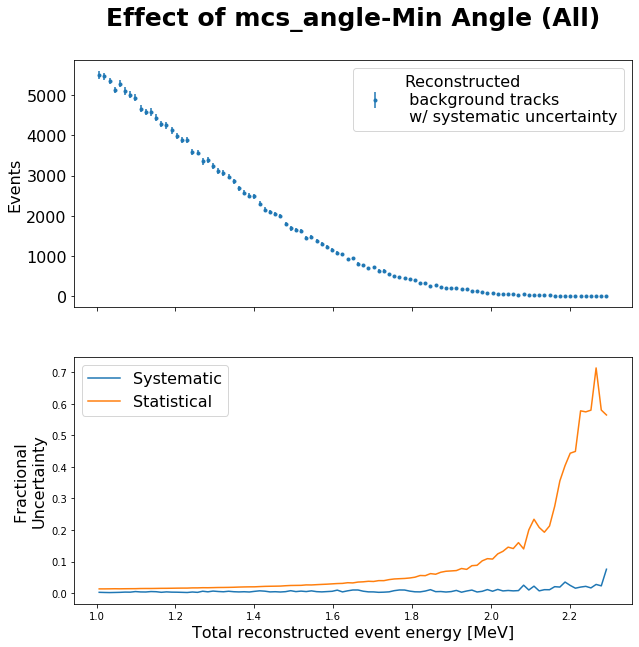

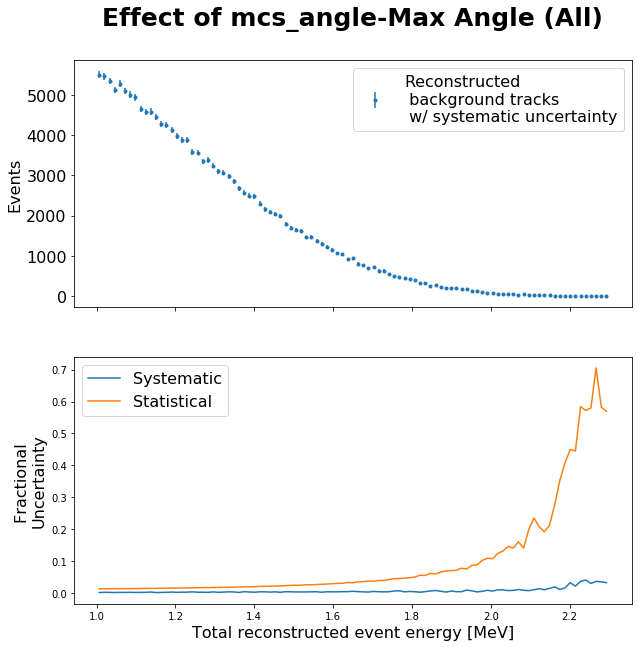

In [10]:
weight_mcs_all_g1 = mcs_weight(df_particles.groupby('event').first(), 'mcs_min')
weight_mcs_all_g2 = mcs_weight(df_particles.groupby('event').first(), 'mcs_max')

mcs_weight_ave_g1 = eplot(df_particles.groupby('event')['reco_energy'].first(), weight_mcs_all_g1, sample_size, 'mcs_angle-Min Angle (All)')
mcs_weight_ave_g2 = eplot(df_particles.groupby('event')['reco_energy'].first(), weight_mcs_all_g2, sample_size, 'mcs_angle-Max Angle (All)')

print('Average Uncertainty Min Angle:' + str(mcs_weight_ave_g1))
print('Average Uncertainty Max Angle:' + str(mcs_weight_ave_g2))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in longlong_scalars


Average Uncertainty Selected Min Angle:0.009479685256835272
Average Uncertainty Selected Max Angle:0.00821644846888811


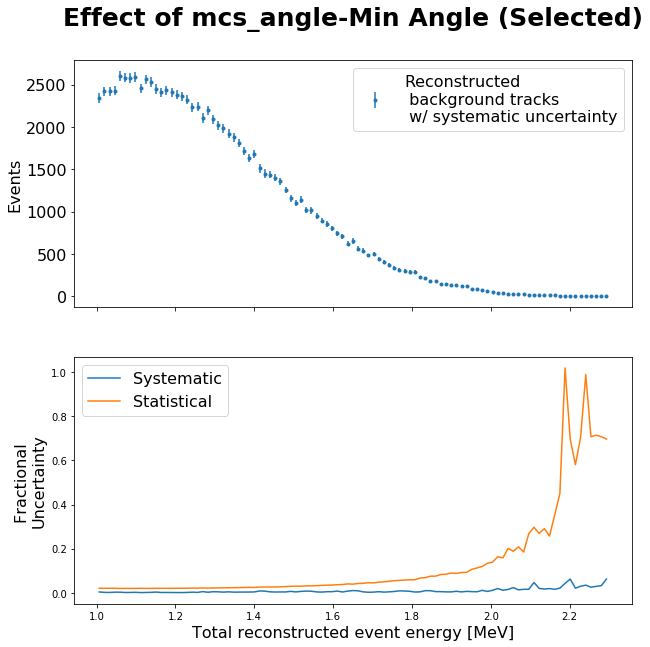

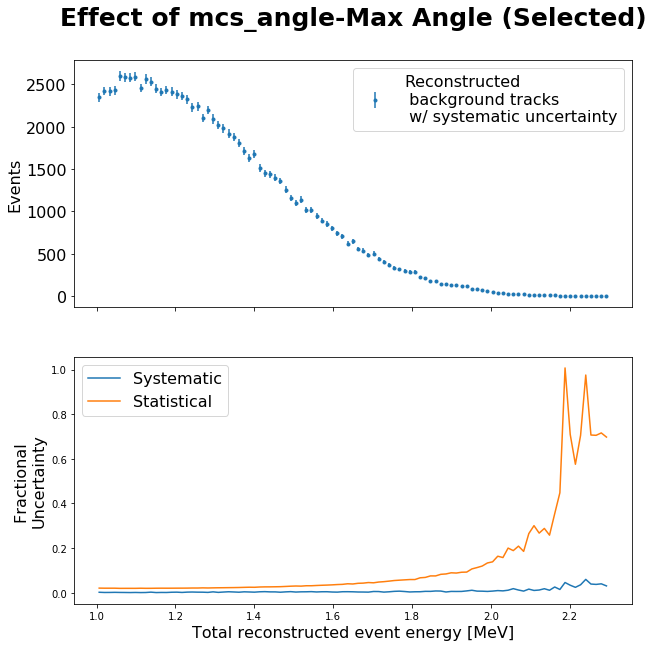

In [11]:
weight_mcs_selection_g1 = mcs_weight(df_particles_selection.groupby('event').first(), 'mcs_min')
weight_mcs_selection_g2 = mcs_weight(df_particles_selection.groupby('event').first(), 'mcs_max')

mcs_weight_ave_selected_g1 = eplot(df_particles_selection.groupby('event')['reco_energy'].first(), weight_mcs_selection_g1, sample_size, 'mcs_angle-Min Angle (Selected)')
mcs_weight_ave_selected_g2 = eplot(df_particles_selection.groupby('event')['reco_energy'].first(), weight_mcs_selection_g2, sample_size, 'mcs_angle-Max Angle (Selected)')

print('Average Uncertainty Selected Min Angle:' + str(mcs_weight_ave_selected_g1))
print('Average Uncertainty Selected Max Angle:' + str(mcs_weight_ave_selected_g2))

## Opening Angle

In [52]:
df_particles['oa_min'] = df_particles.groupby('event')['opening_angle'].transform('min')
df_particles['oa_max'] = df_particles.groupby('event')['opening_angle'].transform('max')
df_particles_selection['oa_min'] = df_particles_selection.groupby('event')['opening_angle'].transform('min')
df_particles_selection['oa_max'] = df_particles_selection.groupby('event')['opening_angle'].transform('max')

sample_size = 3000

def opening_angle_weight(particles, angle):

    sample_size = 3000
    weight_oa = np.zeros((sample_size, len(particles[angle])))

    for i in range(0,sample_size):
        syst_unc = np.random.normal(0, 0.1)
        bin_width = np.random.uniform()*(1-.1)+.1
        oabins = np.arange(0, 3.2, bin_width)

        for j in range(len(oabins) - 1):
            bin_slice = (particles[angle] >= oabins[j])&(particles[angle] < oabins[j+1])
            slope = -1.6
            particles.loc[bin_slice, 'weight_oa'] = ((1 + syst_unc)*np.cos(particles[angle]) + slope)/(np.cos(particles[angle]) + slope)

#         weight_norm = len(particles['event'].unique())/particles.groupby('event')['weight'].first().sum()
        weight_norm = len(particles)/particles['weight_mcs'].sum()
        particles['weight_oa'] = particles['weight_oa']*weight_norm
        weight_oa[i] = particles['weight_oa']
        
    return weight_oa
        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Average Uncertainty:0.0053794670087513085
Average Selected Uncertainty:0.006693708078340917


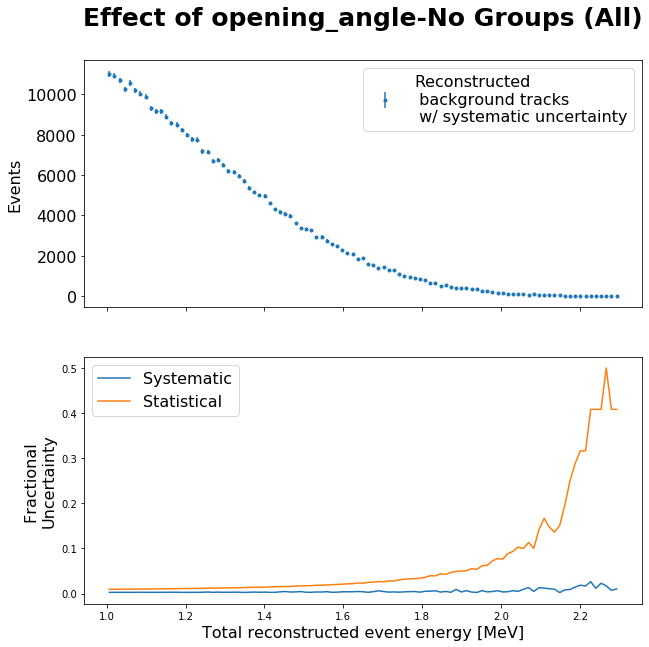

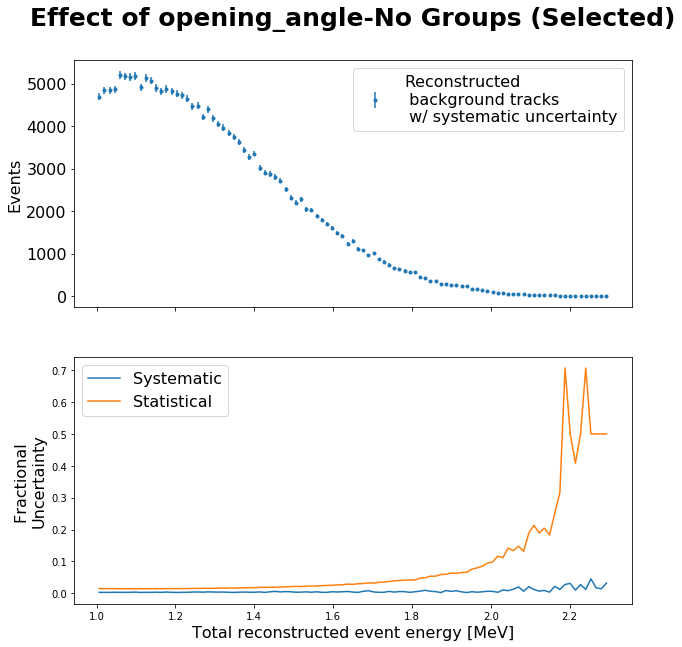

In [53]:
# weight_oa_all_BG = opening_angle_weight(df_BG_particles, 'opening_angle')
# weight_oa_selection_BG = opening_angle_weight(df_BG_particles_selection, 'opening_angle')
weight_oa_all = opening_angle_weight(df_particles, 'opening_angle')
weight_oa_selection = opening_angle_weight(df_particles_selection, 'opening_angle')

# oa_weight_ave_BG = eplot(df_BG_particles['reco_energy'], weight_oa_all_BG, sample_size, 'opening_angle-No Groups-BG (All)')
# oa_weight_ave_selected_BG = eplot(df_BG_particles_selection['reco_energy'], weight_oa_selection_BG, sample_size, 'opening_angle-No Groups-BG (Selected)')
oa_weight_ave = eplot(df_particles['reco_energy'], weight_oa_all, sample_size, 'opening_angle-No Groups (All)')
oa_weight_ave_selected = eplot(df_particles_selection['reco_energy'], weight_oa_selection, sample_size, 'opening_angle-No Groups (Selected)')

# print('Average Background Uncertainty:' + str(oa_weight_ave_BG))
# print('Average Selected Background Uncertainty:' + str(oa_weight_ave_selected_BG))
print('Average Uncertainty:' + str(oa_weight_ave))
print('Average Selected Uncertainty:' + str(oa_weight_ave_selected))

Average Uncertainty Min Angle:0.005223430798297559
Average Uncertainty Max Angle:0.005297485204684191


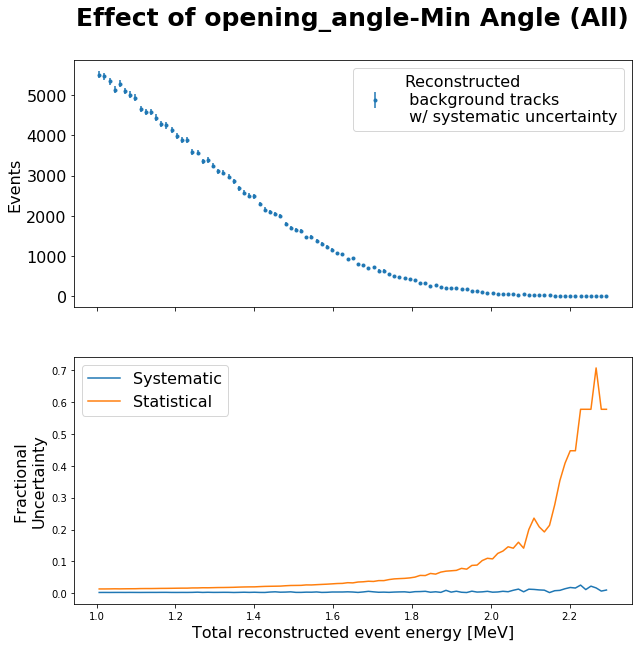

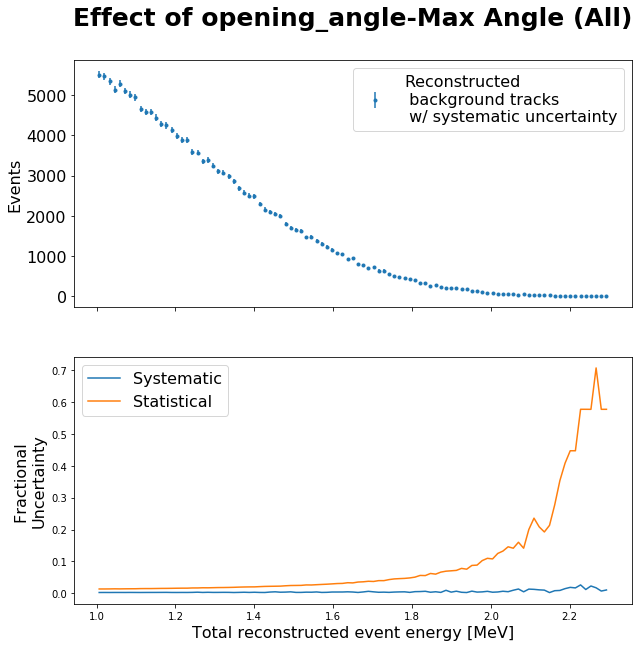

In [54]:
weight_oa_all_g1 = opening_angle_weight(df_particles.groupby('event').first(), 'oa_min')
weight_oa_all_g2 = opening_angle_weight(df_particles.groupby('event').first(), 'oa_max')

oa_weight_ave_g1 = eplot(df_particles.groupby('event')['reco_energy'].first(), weight_oa_all_g1, sample_size, 'opening_angle-Min Angle (All)')
oa_weight_ave_g2 = eplot(df_particles.groupby('event')['reco_energy'].first(), weight_oa_all_g2, sample_size, 'opening_angle-Max Angle (All)')

print('Average Uncertainty Min Angle:' + str(oa_weight_ave_g1))
print('Average Uncertainty Max Angle:' + str(oa_weight_ave_g2))

Average Uncertainty Selected Min Angle:0.006727465686284394
Average Uncertainty Selected Max Angle:0.006518087349569989


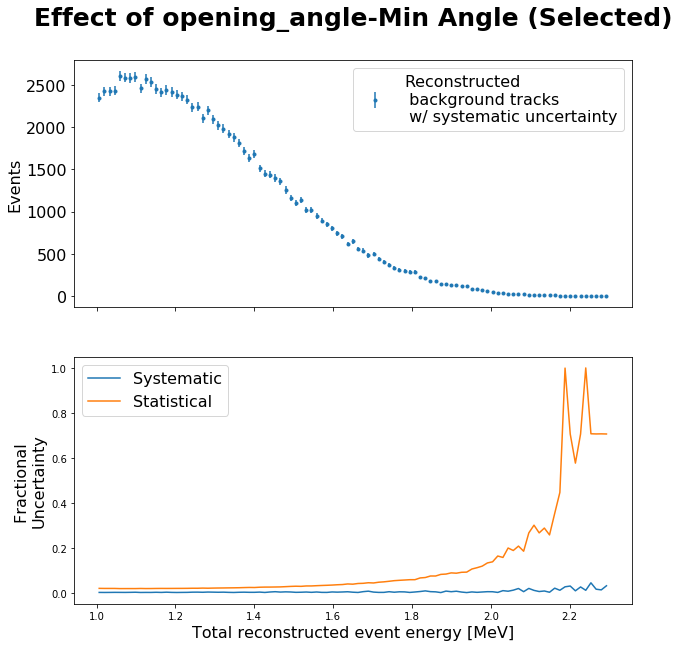

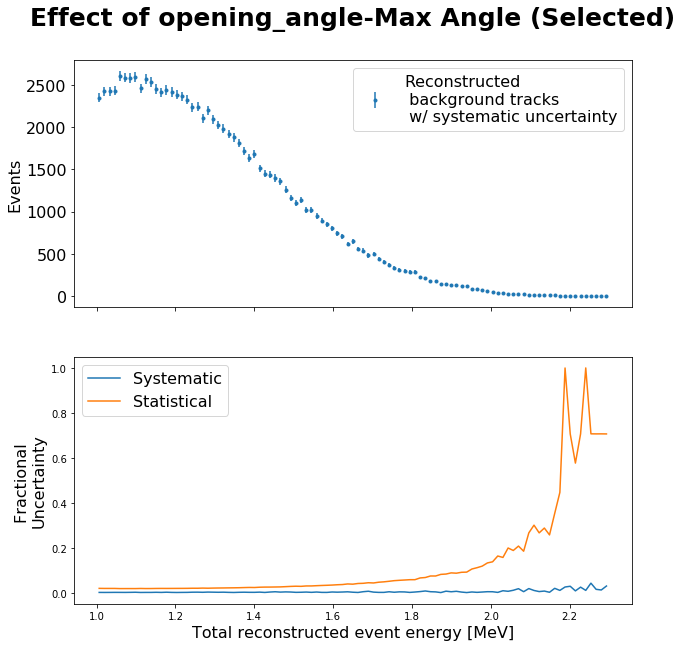

In [55]:
weight_oa_selection_g1 = opening_angle_weight(df_particles_selection.groupby('event').first(), 'oa_min')
weight_oa_selection_g2 = opening_angle_weight(df_particles_selection.groupby('event').first(), 'oa_max')

oa_weight_ave_selected_g1 = eplot(df_particles_selection.groupby('event')['reco_energy'].first(), weight_oa_selection_g1, sample_size, 'opening_angle-Min Angle (Selected)')
oa_weight_ave_selected_g2 = eplot(df_particles_selection.groupby('event')['reco_energy'].first(), weight_oa_selection_g2, sample_size, 'opening_angle-Max Angle (Selected)')

print('Average Uncertainty Selected Min Angle:' + str(oa_weight_ave_selected_g1))
print('Average Uncertainty Selected Max Angle:' + str(oa_weight_ave_selected_g2))

## Total Systematic Uncertainty

In [56]:
total_unc_ave_BG_selected = np.sqrt(brem_weight_ave_selected_BG**2+mcs_weight_ave_selected_BG**2)

total_unc_ave_selected = np.sqrt(brem_weight_ave_selected_g**2+mcs_weight_ave_selected_g1**2+mcs_weight_ave_selected_g2**2+oa_weight_ave_selected_g1**2+oa_weight_ave_selected_g2**2)

print('Total Backgroung Sys. Unc. = ' + str(total_unc_ave_BG_selected))
print('Total Signal Sys. Unc. = ' + str(total_unc_ave_selected))

Total Backgroung Sys. Unc. = 0.027567672204478377
Total Signal Sys. Unc. = 0.0235858068328588


Total Background Sys. Unc. = 0.027957234441955563
Total Signal Sys. Unc. = 0.025587180917573175


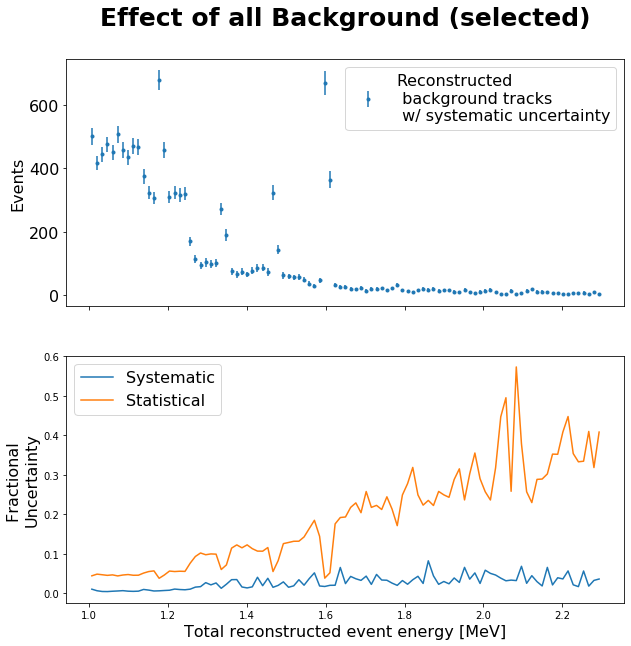

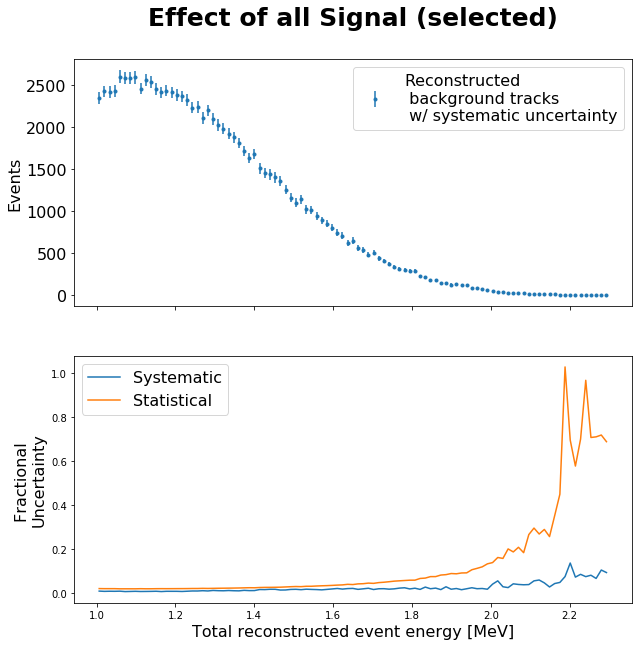

In [57]:
total_weight_BG = weight_all_selection_BG*weight_mcs_selection_BG
total_weight =  weight_all_selection_g*weight_mcs_selection_g1*weight_mcs_selection_g2*weight_oa_selection_g1*weight_oa_selection_g2

total_unc_ave_BG = eplot(df_BG_particles_selection['reco_energy'], total_weight_BG, sample_size, 'all Background (selected)')
total_unc_ave = eplot(df_particles_selection.groupby('event')['reco_energy'].first(), total_weight, sample_size, 'all Signal (selected)')

print('Total Background Sys. Unc. = ' + str(total_unc_ave_BG))
print('Total Signal Sys. Unc. = ' + str(total_unc_ave))